In this notebook, I have implemented the kinematic bicycle model. The model accepts velocity and steering rate inputs and steps through the bicycle kinematic equations. Once the model is implemented, i will provide a set of inputs to drive the bicycle in a figure 8 trajectory.

The bicycle kinematics are governed by the following set of equations:

\begin{align*}
\dot{x}_c &= v \cos{(\theta + \beta)} \\
\dot{y}_c &= v \sin{(\theta + \beta)} \\
\dot{\theta} &= \frac{v \cos{\beta} \tan{\delta}}{L} \\
\dot{\delta} &= \omega \\
\beta &= \tan^{-1}(\frac{l_r \tan{\delta}}{L})
\end{align*}

where the inputs are the bicycle speed $v$ and steering angle rate $\omega$. The input can also directly be the steering angle $\delta$ rather than its rate in the simplified case. The Python model will allow us both implementations.

In order to create this model, i have made use of Python class objects. This allows us to store the state variables as well as make functions for implementing the bicycle kinematics. 

The bicycle begins with zero initial conditions, has a maximum turning rate of 1.22 rad/s, a wheelbase length of 2m, and a length of 1.2m to its center of mass from the rear axle.

In [42]:
from notebook_grader import BicycleSolution, grade_bicycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import sin, cos, tan, atan2

class Bicycle():
    def __init__(self):
        self.xc = 0
        self.yc = 0
        self.theta = 0
        self.delta = 0
        self.beta = 0
        
        self.L = 2
        self.lr = 1.2
        self.w_max = 1.22
        
        self.sample_time = 0.01
        
    def reset(self):
        self.xc = 0
        self.yc = 0
        self.theta = 0
        self.delta = 0
        self.beta = 0

A sample time is required for numerical integration when propagating the kinematics through time. This is set to 10 milliseconds. I also have a reset function which sets all the state variables back to 0. 



Setting up the kinematic Model 

In [57]:
class Bicycle(Bicycle):
    def step(self, v, w):
        
        x_dot = v * cos(self.theta + self.beta)
        y_dot = v * sin(self.theta + self.beta)
        theta_dot = (v * cos(self.beta) * tan(self.delta))/self.L
        delta_dot = max(-self.w_max, min(self.w_max, w))
        self.xc += x_dot * self.sample_time
        self.yc += y_dot * self.sample_time
        self.theta += theta_dot * self.sample_time
        self.delta += delta_dot * self.sample_time
        self.beta = atan2(self.lr * tan(self.delta), self.L)
        pass



With the model setup, I can now start giving bicycle inputs and producing trajectories. 

Suppose if i want the model to travel a circle of radius 10 m in 20 seconds. Using the relationship between the radius of curvature and the steering angle, the desired steering angle can be computed.

\begin{align*}
    \tan{\delta} &= \frac{L}{r} \\
    \delta &= \tan^{-1}(\frac{L}{r}) \\
           &= \tan^{-1}(\frac{2}{10}) \\
           &= 0.1974
\end{align*}

If the steering angle is directly set to 0.1974 using a simplied bicycled model, then the bicycle will travel in a circle without requiring any additional steering input. 

The desired speed can be computed from the circumference of the circle:

\begin{align*}
    v &= \frac{d}{t}\\
     &= \frac{2 \pi 10}{20}\\
     &= \pi
\end{align*}

Implementing Bicycle model to run in the expected trajectory

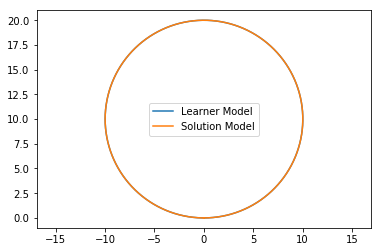

In [58]:
sample_time = 0.01
time_end = 20
model = Bicycle()
solution_model = BicycleSolution()

# set delta directly
model.delta = np.arctan(2/10)
solution_model.delta = np.arctan(2/10)

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step(np.pi, 0)
    
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    solution_model.step(np.pi, 0)
    
    #Here we set beta (the slip angle) to 0 for both, 
    #effectively aligning with the simplified circle condition.
    model.beta = 0
    solution_model.beta=0
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.plot(x_solution, y_solution,label='Solution Model')
plt.legend()
plt.show()

The plot above shows the desired circle of 10m radius. We can observe that the path is slightly offset which is caused by the sideslip effects due to $\beta$. By forcing $\beta = 0$, we can see that the offset disappears and the circle becomes centered at (0,10). 

However, in practice the steering angle cannot be directly set and must be changed through angular rate inputs $\omega$. Thus in the cell below we set angular rate inputs to generate the same circle trajectory. The speed $v$ is still maintained at $\pi$ m/s

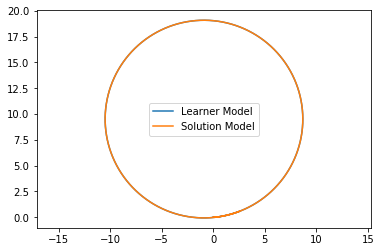

In [59]:
sample_time = 0.01
time_end = 20
model.reset()
solution_model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    
    if model.delta < np.arctan(2/10):
        model.step(np.pi, model.w_max)
    else:
        model.step(np.pi, 0)
        
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    
    if solution_model.delta < np.arctan(2/10):
        solution_model.step(np.pi, model.w_max)
    else:
        solution_model.step(np.pi, 0)    

plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.plot(x_solution, y_solution,label='Solution Model')
plt.legend()
plt.show()

Implementing the Bicycle model on Square Path. 

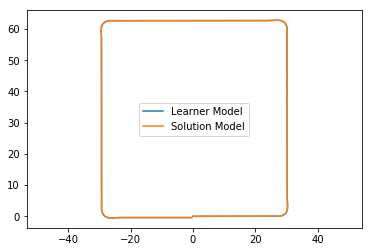

In [60]:
sample_time = 0.01
time_end = 60
model.reset()
solution_model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

# maintain velocity at 4 m/s
v_data = np.zeros_like(t_data)
v_data[:] = 4 

w_data = np.zeros_like(t_data)

# ==================================
#  Square Path: set w at corners only
# ==================================
w_data[670:670+100] = 0.753
w_data[670+100:670+100*2] = -0.753
w_data[2210:2210+100] = 0.753
w_data[2210+100:2210+100*2] = -0.753
w_data[3670:3670+100] = 0.753
w_data[3670+100:3670+100*2] = -0.753
w_data[5220:5220+100] = 0.753
w_data[5220+100:5220+100*2] = -0.753

# ==================================
#  Step through bicycle model
# ==================================
for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step(v_data[i], w_data[i])

    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    solution_model.step(v_data[i], w_data[i])
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.plot(x_solution, y_solution,label='Solution Model')
plt.legend()
plt.show()

Implementing Bicycle model on Spiral path

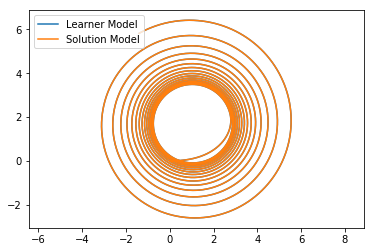

In [ ]:
sample_time = 0.01
time_end = 60
model.reset()
solution_model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

# maintain velocity at 4 m/s
v_data = np.zeros_like(t_data)
v_data[:] = 4 

w_data = np.zeros_like(t_data)

#==================================
#Spiral Path: high positive w, then small negative w
#==================================
w_data[:] = -1/100
w_data[0:100] = 1

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step(v_data[i], w_data[i])

    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    solution_model.step(v_data[i], w_data[i])
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.plot(x_solution, y_solution,label='Solution Model')
plt.legend()
plt.show()

Implementing Bicycle model on Wavy path

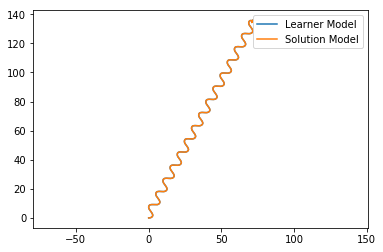

In [63]:
sample_time = 0.01
time_end = 60
model.reset()
solution_model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

# maintain velocity at 4 m/s
v_data = np.zeros_like(t_data)
v_data[:] = 4 

w_data = np.zeros_like(t_data)
# ==================================
#  Wave Path: square wave w input
# ==================================
w_data[:] = 0
w_data[0:100] = 1
w_data[100:300] = -1
w_data[300:500] = 1
w_data[500:5700] = np.tile(w_data[100:500], 13)
w_data[5700:] = -1

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step(v_data[i], w_data[i])

    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    solution_model.step(v_data[i], w_data[i])
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.plot(x_solution, y_solution,label='Solution Model')
plt.legend()
plt.show()

The Task is to make bicycle to travel a figure eight trajectory. Both circles in the figure eight have a radius of 8m and the path should complete in 30 seconds. The path begins at the bottom of the left circle and is shown in the figure below:

![title](figure8.png)

Implementing Bicycle model on figure_8 Trajectory

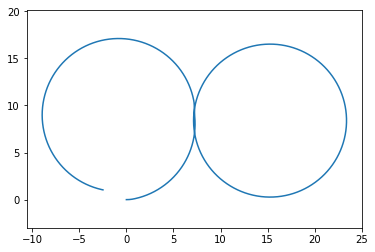

In [64]:
sample_time = 0.01
time_end = 30
model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

rad = 8
delta =  0.993* np.arctan(model.L / rad)
v_data[:] = ((2 * np.pi * rad) * 2)/(time_end)

# Main loop:
# For each time step, log the current position.
# Divide the path into eight segments and apply ω to steer toward delta, then hold.
# Segment logic:
# First segment: increase δ toward delta by applying ω = w_max until reaching delta; then ω = 0.
# Second segment: decrease δ toward -delta by applying ω = -w_max until reaching -delta; then ω = 0.
# Third segment: increase toward delta again, then stop, forming the second circle.
# Saved the applied w into w_data alongside v into v_data.

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    
    #As velocity is constant throughout, we will divide the path into 8 slices
    # w changes at t_0 and t_5.
    
    if i <= t_data.shape[0]/8:
        if model.delta < delta:
            model.step(v_data[i], model.w_max)
            w_data[i] = model.w_max
        else :
            model.step(v_data[i],0)
            w_data[i] = 0
            
    elif i <= (5.1*t_data.shape[0])/8:
        if model.delta > -delta:
            model.step(v_data[i], -model.w_max)
            w_data[i] = -model.w_max
        else:
            model.step(v_data[i], 0)
            w_data[i] = 0
            
    else:
        if model.delta < delta:
            model.step(v_data[i], model.w_max)
            w_data[i] = model.w_max
        else:
            model.step(v_data[i], 0)
            w_data[i] = 0         
# ==================================
plt.axis('equal')
plt.plot(x_data, y_data)
plt.show()

Test Case : We will now run your speed and angular rate inputs through our bicycle model solution. This is to ensure that your trajectory is correct along with your model. The cell below will display the path generated by our model along with some waypoints on a desired figure 8. Surrounding these waypoints are error tolerance circles with radius 1.5m, your solution will pass the grader if the trajectory generated stays within 80% of these circles.

Assessment passed! Your trajectory meets 100.0% of the waypoints.


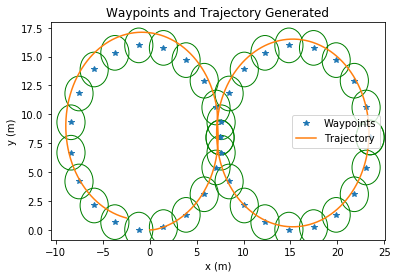

In [65]:
grade_bicycle(t_data,v_data,w_data)

The cell below will save the time and vehicle inputs as text file named $\textit{figure8.txt}$. To locate the file, change the end of your web directory to $\textit{/notebooks/Course_1_Module_4/figure8.txt}$

Once you are there, you can download the file and submit to the Coursera grader to complete this assessment.

In [66]:
data = np.vstack([t_data, v_data, w_data]).T
np.savetxt('figure8.txt', data, delimiter=', ')

Implmenting Bicycle model on equilateral triangle

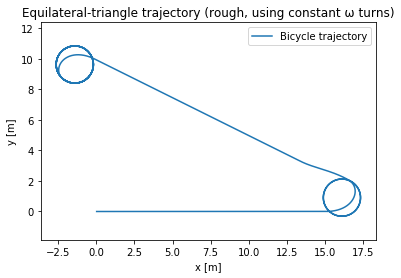

In [50]:
# Parameters (tune as needed)
sample_time = 0.01
time_end = 30.0

# Reset model
model.reset()

# Time grid
t_data = np.arange(0, time_end, sample_time)
n = t_data.size

# State/action arrays
x_data = np.zeros(n)
y_data = np.zeros(n)
v_data = np.zeros(n)
w_data = np.zeros(n)

# Triangle (equilateral) parameters
v = 3.0  # forward speed (m/s)
straight_time = 5.0  # seconds of straight travel per side
turn_time = 1.2      # seconds spent turning at each corner
omega_turn = 5
# rad/s, adjust to fit your vehicle

# Fill velocity data (constant speed)
v_data[:] = v

# Build the equilateral-triangle pattern:
# Three straight segments, each followed by a turn of 120° exterior (approx.)
# We'll implement: straight -> turn left by some amount -> straight -> turn -> straight -> turn
# For simplicity, use three corners with the same turn direction (left turns)
segments_straight = int(straight_time / sample_time)
segments_turn = int(turn_time / sample_time)

idx = 0
turn_dir = 1  # +1 for left turn, -1 for right turn

# We'll create three sides: straight, turn, straight, turn, straight, turn
for side in range(3):
    # Straight segment for this side
    for _ in range(segments_straight):
        if idx >= n:
            break
        w_data[idx] = 0.0
        idx += 1

    # Corner turn to head toward next side
    for _ in range(segments_turn):
        if idx >= n:
            break
        w_data[idx] = turn_dir * omega_turn
        idx += 1

    # After the turn, flip direction for the next corner if needed
    turn_dir *= -1  # alternate directions to complete a loop

# If there are remaining steps (due to integer rounding), keep straight
while idx < n:
    w_data[idx] = 0.0
    idx += 1

# Run the simulation
for i in range(n):
    model.step(v_data[i], w_data[i])
    x_data[i] = model.xc
    y_data[i] = model.yc

# Plot result
plt.axis('equal')
plt.plot(x_data, y_data, label='Bicycle trajectory')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Equilateral-triangle trajectory (rough, using constant ω turns)')
plt.show()

It's difficult to generate desired trajectories by pre-setting the inputs for these kind of trajectories.The next module on vehicle control will show you an easier and more accurate method. See you there!